In [0]:
!apt-get -qq install -y graphviz && pip install -q pydot

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


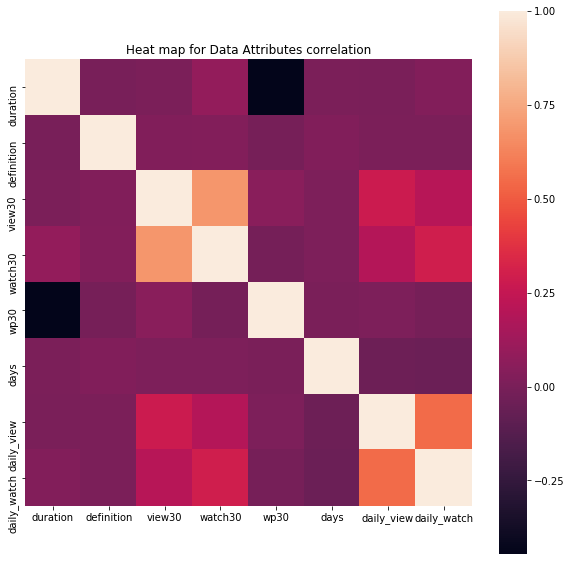

In [0]:
from math import sqrt
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns



df = pd.read_table('/content/drive/My Drive/autos.txt')
#newdf=df
df.drop(['category'], axis = 1,inplace = True)
#====== plot the correlation matrix heat plot
corrmat=df.corr()
corrmat['daily_watch'].sort_values(ascending=False)
f, ax = plt.subplots(1,figsize=(10, 10))
sns.heatmap(corrmat, vmax=1, square=True)
plt.title('Heat map for Data Attributes correlation')
plt.show()

In [0]:
import os, time, datetime
import numpy as np
from collections import defaultdict
from scipy.stats import gaussian_kde
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def exponent(x, pos):
    """ The two args are the value and tick position. """
    return '%1.0f' % (10 ** x)


def get_duration_wp_from_file(filepath, duration_wp_tuple, duration_stats_dict):
    with open(filepath, 'r') as fin:
        fin.readline()
        for line in fin:
            _, _, duration, dump = line.rstrip().split('\t', 3)
            _, _, _, _, _, view30, _, wp30, _ = dump.split('\t', 8)
            duration = int(duration)
            wp30 = float(wp30)
            if int(view30) >= 100:
                duration_wp_tuple.append((duration, wp30))
                duration_stats_dict[duration] += 1


def remove_bad_bins(x_axis, bin_matrix, min_bin=25):
    x_axis = x_axis[:len(bin_matrix)]
    bad_bin_idx = []
    for idx, bin in enumerate(bin_matrix):
        if len(bin) < min_bin:
            bad_bin_idx.append(idx)
    for idx in bad_bin_idx[::-1]:
        x_axis.pop(idx)
        bin_matrix.pop(idx)
    return x_axis, bin_matrix


def loading_data(input_loc, bin_number, min_bin):
    # setting parameters
    duration_wp_tuple = []
    duration_stats_dict = defaultdict(int)

    # load dataset
    if os.path.isdir(input_loc):
        for subdir, _, files in os.walk(input_loc):
            for f in files:
                # get tweeted music videos
                if f.startswith('autos'):
                    print('>>> Start to load data: {0}...'.format(f))
                    get_duration_wp_from_file(os.path.join(subdir, f), duration_wp_tuple, duration_stats_dict)
    else:
        print('>>> Start to load data: {0}...'.format(input_loc))
        get_duration_wp_from_file(input_loc, duration_wp_tuple, duration_stats_dict)

    # sort by duration in ascent order
    sorted_duration_wp_tuple = sorted(duration_wp_tuple, key=lambda x: x[0])

    # get duration split point
    x_axis = list(np.linspace(xmin, xmax, bin_number))

    # put videos in correct bins
    bin_matrix = []
    bin_list = []
    bin_idx = 0
    # put dur-wp tuple in the correct bin
    for item in sorted_duration_wp_tuple:
        if np.log10(item[0]) > x_axis[bin_idx]:
            bin_matrix.append(bin_list)
            bin_idx += 1
            bin_list = []
        bin_list.append(item[1])
    if len(bin_list) > 0:
        bin_matrix.append(bin_list)
    bin_matrix = [np.array(x) for x in bin_matrix]

    x_axis, bin_matrix = remove_bad_bins(x_axis, bin_matrix, min_bin)

    # sanity check
    to_check = False
    if to_check:
        print('videos in each bin')
        for i in range(len(x_axis)):
            print('duration split point: {0}; number of videos in bin: {1}'.format(x_axis[i], len(bin_matrix[i])))
        print('num of bins: {0}'.format(len(x_axis)))
    return x_axis, bin_matrix, duration_wp_tuple
  
  

xmin, xmax = 1, 5
ymin, ymax = 0, 1
cornflower_blue = '#6495ed'
tomato = '#ff6347'  
input_loc = '/content/drive/My Drive'
tweeted_x_axis, tweeted_bin_matrix, tweeted_tuple = loading_data(input_loc, bin_number=150, min_bin=50)

tweeted_df_x = [np.log10(x[0]) for x in tweeted_tuple]
tweeted_df_y = [x[1] for x in tweeted_tuple]
# KDE for top marginal
tweeted_kde_x = gaussian_kde(tweeted_df_x)
# KDE for right marginal
tweeted_kde_y = gaussian_kde(tweeted_df_y)  
x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)



>>> Start to load data: autos.txt...


In [0]:
tweeted_kde_x(1)

array([0.01853024])

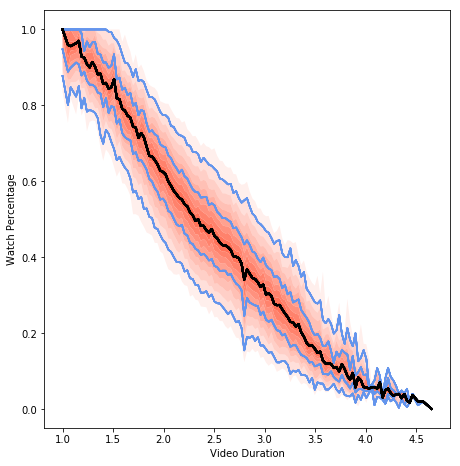

In [0]:
gs = gridspec.GridSpec(2, 2, width_ratios=[8, 1], height_ratios=[1, 8])
fig = plt.figure(figsize=(9, 9.5))
ax1 = plt.subplot(gs[1, 0])
plt.ylabel('Watch Percentage')
plt.xlabel('Video Duration')
for t in np.arange(5, 50, 5):
  ax1.fill_between(tweeted_x_axis, [np.percentile(x, 50-t) for x in tweeted_bin_matrix],
                   [np.percentile(x, 55-t) for x in tweeted_bin_matrix], facecolor=tomato, alpha=(100-2*t)/100, lw=0, zorder=1)
  ax1.fill_between(tweeted_x_axis, [np.percentile(x, 45+t) for x in tweeted_bin_matrix],
                   [np.percentile(x, 50+t) for x in tweeted_bin_matrix], facecolor=tomato, alpha=(100-2*t)/100, lw=0, zorder=1)
  for t in [10, 30, 70, 90]:
    ax1.plot(tweeted_x_axis, [np.percentile(x, t) for x in tweeted_bin_matrix], color=cornflower_blue , alpha=1, zorder=5)
    ax1.plot(tweeted_x_axis, [np.percentile(x, 50) for x in tweeted_bin_matrix], color='k', alpha=0.5, zorder=20, lw=2)



Text(0.5, 1.0, 'Inconsistency in Daily views and daily watch')

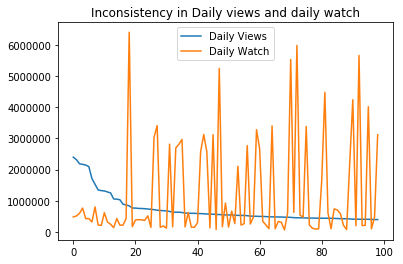

In [0]:
#discrepancy between views and watch counts
sorteddf=df.sort_values(by='daily_view', ascending=False)
top_dialyview=sorteddf['daily_view'].values[1:100]
top_dialywatch=sorteddf['daily_watch'].values[1:100]
plt.plot(top_dialyview,label='Daily Views')
plt.plot(top_dialywatch,label='Daily Watch')
plt.legend()
plt.title('Inconsistency in Daily views and daily watch')


In [0]:
from math import sqrt
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
#plaidml.keras.install_backend()
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


#---------------- convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
  
  
dataset = pd.read_table('/content/drive/My Drive/autos.txt', delim_whitespace=True,
                            header=0, index_col=1)
values = dataset[['duration', 'definition', 'category',
                      'view30', 'watch30', 'wp30', 'days', 'daily_view',
                      'daily_watch']].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 1
n_features = 9
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


(8130877, 18)


In [0]:
# split into train and test sets
values = reframed.values
n_obs = n_hours * n_features
temp_train, temp_test, temp_trainlabel, temp_testlabel = train_test_split(values[:, :n_obs], values[:, n_features],test_size=0.95)
print(temp_train.shape)
train_X, test_X, train_y, test_y = train_test_split(temp_train, temp_trainlabel, test_size=0.2)
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(406543, 9)
(325234, 9) 325234 (325234,)
(325234, 1, 9) (325234,) (81309, 1, 9) (81309,)


In [0]:
#normal LSTM model with few memory units
from keras.models import Sequential
from keras.layers import Dense, Bidirectional,MaxPooling1D,BatchNormalization, Dropout,TimeDistributed
from keras.layers import LSTM

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model


model_1 = Sequential()
model_1.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
#model_1.add(MaxPooling1D(pool_size=2, data_format='channels_first'))
model_1.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True))

model_1.add(Dropout(0.25))
#model.add(Dense(128, activation='relu'))
model_1.add(Dense(1))
model_1.summary()
#visualise the model
SVG(model_to_dot(model_1, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
plot_model(model_1, to_file='/content/drive/My Drive/LSTMmodel1.png', show_shapes=True, show_layer_names=True)

W0812 10:27:08.781236 140368448980864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 10:27:08.828489 140368448980864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 10:27:08.839145 140368448980864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 10:27:09.137092 140368448980864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0812 10:27:09.161748 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,537
Trainable params: 5,473
Non-trainable params: 64
_________________________________________________________________


In [0]:
from keras import backend as K
from keras.callbacks import TensorBoard
from keras import optimizers

#run the model
tbCallBack = TensorBoard(log_dir='tb_logs', 
                         histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=128,
                         write_images=True)
adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_1.compile(loss='mae', optimizer=adam)
# fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False,callbacks=[tbCallBack])
history_1 = model_1.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), verbose=1, shuffle=False)

W0812 09:01:52.370916 140700324304768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0812 09:01:52.706820 140700324304768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0812 09:01:53.677251 140700324304768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 325234 samples, validate on 81309 samples
Epoch 1/50
325234/325234 [==============================] - 23s 70us/step - loss: 0.1272 - val_loss: 0.0067
Epoch 2/50
325234/325234 [==============================] - 18s 54us/step - loss: 0.0157 - val_loss: 0.0057
Epoch 3/50
325234/325234 [==============================] - 18s 55us/step - loss: 0.0023 - val_loss: 0.0010
Epoch 4/50
325234/325234 [==============================] - 18s 54us/step - loss: 0.0014 - val_loss: 8.5812e-04
Epoch 5/50
325234/325234 [==============================] - 18s 55us/step - loss: 0.0012 - val_loss: 5.5338e-04
Epoch 6/50
325234/325234 [==============================] - 18s 54us/step - loss: 0.0011 - val_loss: 7.6112e-04
Epoch 7/50
325234/325234 [==============================] - 18s 55us/step - loss: 0.0011 - val_loss: 2.6394e-04
Epoch 8/50
325234/325234 [==============================] - 18s 55us/step - loss: 0.0010 - val_loss: 8.1014e-04
Epoch 9/50
325234/325234 [==============================] - 17s 5

In [0]:
#normal LSTM model with more memory units (#LSTM2)
from keras.models import Sequential
from keras.layers import Dense, Bidirectional,MaxPooling1D,BatchNormalization, Dropout,TimeDistributed
from keras.layers import LSTM

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model


model_2 = Sequential()
model_2.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
#model_2.add(MaxPooling1D(pool_size=2, data_format='channels_first'))
model_2.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True))

model_2.add(Dropout(0.25))
#model.add(Dense(128, activation='relu'))
model_2.add(Dense(1))
model_2.summary()
#visualise the model
SVG(model_to_dot(model_2, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
plot_model(model_2, to_file='/content/drive/My Drive/LSTMmodel2.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               70656     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 71,297
Trainable params: 71,041
Non-trainable params: 256
_________________________________________________________________


In [0]:
from keras import backend as K
from keras.callbacks import TensorBoard
from keras import optimizers

#run the model

adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_2.compile(loss='mae', optimizer=adam)
# fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False,callbacks=[tbCallBack])
history_2 = model_2.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 325234 samples, validate on 81309 samples
Epoch 1/50
325234/325234 [==============================] - 18s 56us/step - loss: 0.0578 - val_loss: 0.0153
Epoch 2/50
325234/325234 [==============================] - 17s 53us/step - loss: 0.0046 - val_loss: 0.0013
Epoch 3/50
325234/325234 [==============================] - 17s 53us/step - loss: 0.0013 - val_loss: 9.5858e-04
Epoch 4/50
325234/325234 [==============================] - 17s 53us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/50
325234/325234 [==============================] - 17s 53us/step - loss: 9.7424e-04 - val_loss: 4.1606e-04
Epoch 6/50
325234/325234 [==============================] - 17s 53us/step - loss: 9.2767e-04 - val_loss: 2.5803e-04
Epoch 7/50
325234/325234 [==============================] - 17s 53us/step - loss: 9.0207e-04 - val_loss: 2.9031e-04
Epoch 8/50
325234/325234 [==============================] - 17s 53us/step - loss: 8.8556e-04 - val_loss: 2.6905e-04
Epoch 9/50
325234/325234 [=======================

In [0]:
#proposed model
from keras.models import Sequential
from keras.layers import Dense, Bidirectional,MaxPooling1D,BatchNormalization, Dropout,TimeDistributed
from keras.layers import LSTM

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model


model_3 = Sequential()
model_3.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
#model_3.add(MaxPooling1D(pool_size=2, data_format='channels_first'))
model_3.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True))

#model.add(Bidirectional(LSTM(50, return_sequences=True),input_shape=(train_X.shape[1], train_X.shape[2])))
model_3.add(Bidirectional(LSTM(128)))
#model.add(LSTM(64))
#model.add(MaxPooling1D(pool_size=2, data_format='channels_first'))
model_3.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True))

model_3.add(Dense(256, activation='softmax'))
model_3.add(Dropout(0.25))
#model.add(Dense(128, activation='relu'))
model_3.add(Dense(1))
model_3.summary()
#visualise the model
SVG(model_to_dot(model_3, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
plot_model(model_3, to_file='/content/drive/My Drive/LSTMmodel3.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 512)            544768    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 512)            4         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               656384    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total para

In [0]:
LOG_DIR = 'tb_logs'

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

import os
if not os.path.exists(LOG_DIR):
  os.makedirs(LOG_DIR)
  
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-08-12 09:31:08--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.200.184.208, 52.2.175.150, 52.200.233.201, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.200.184.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  36.8MB/s    in 0.4s    

2019-08-12 09:31:08 (36.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://da02bb7a.ngrok.io


In [0]:
from keras import backend as K
from keras.callbacks import TensorBoard
from keras import optimizers

#run the model
tbCallBack = TensorBoard(log_dir='tb_logs', 
                         histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=128,
                         write_images=True)
adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_3.compile(loss='mae', optimizer=adam)
# fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False,callbacks=[tbCallBack])
history_3 = model_3.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 325234 samples, validate on 81309 samples
Epoch 1/50
325234/325234 [==============================] - 50s 153us/step - loss: 0.0018 - val_loss: 7.1830e-04
Epoch 2/50
325234/325234 [==============================] - 47s 144us/step - loss: 0.0010 - val_loss: 7.4666e-04
Epoch 3/50
325234/325234 [==============================] - 47s 143us/step - loss: 8.7717e-04 - val_loss: 5.2429e-04
Epoch 4/50
325234/325234 [==============================] - 46s 143us/step - loss: 7.9378e-04 - val_loss: 7.4505e-04
Epoch 5/50
325234/325234 [==============================] - 47s 143us/step - loss: 7.4185e-04 - val_loss: 3.4725e-04
Epoch 6/50
325234/325234 [==============================] - 47s 143us/step - loss: 6.9333e-04 - val_loss: 6.3337e-04
Epoch 7/50
325234/325234 [==============================] - 47s 144us/step - loss: 6.6163e-04 - val_loss: 7.5492e-04
Epoch 8/50
325234/325234 [==============================] - 47s 143us/step - loss: 6.3157e-04 - val_loss: 2.6807e-04
Epoch 9/50
325234/325

Text(0, 0.5, 'MAE')

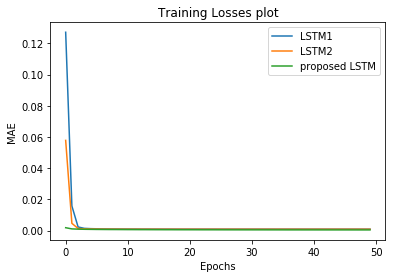

In [0]:
plt.plot(history_1.history['loss'],label='LSTM1')
plt.plot(history_2.history['loss'],label='LSTM2')
plt.plot(history_3.history['loss'],label='proposed LSTM')

#plt.plot(history.history['val_loss'],label='Validation losses')
plt.legend()
plt.title('Training Losses plot')
plt.xlabel('Epochs')
plt.ylabel('MAE')



Text(0, 0.5, 'MAE')

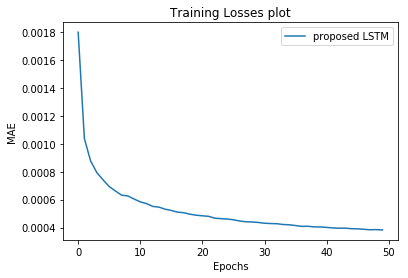

In [0]:
plt.plot(history_3.history['loss'],label='proposed LSTM')

#plt.plot(history.history['val_loss'],label='Validation losses')
plt.legend()
plt.title('Training Losses plot')
plt.xlabel('Epochs')
plt.ylabel('MAE')

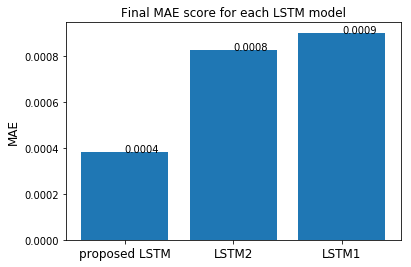

In [0]:
label=['proposed LSTM','LSTM2','LSTM1']
import numpy as np
index = np.arange(len(label))

plt.bar(index,[history_3.history['loss'][49],history_2.history['loss'][49],history_1.history['loss'][49]])
plt.ylabel('MAE', fontsize=12)
plt.xticks(index, label, fontsize=12, rotation=0)
plt.title('Final MAE score for each LSTM model')
plt.text(0,history_3.history['loss'][49],str.format('{0:.4f}',history_3.history['loss'][49]))
plt.text(1,history_2.history['loss'][49],str.format('{0:.4f}',history_2.history['loss'][49]))
plt.text(2,history_1.history['loss'][49],str.format('{0:.4f}',history_1.history['loss'][49]))
plt.show()

In [0]:
predictedY_3=model_3.predict(test_X)
predictedY_2=model_2.predict(test_X)
predictedY_1=model_1.predict(test_X)

Text(0.5, 1.0, 'Predcited popularity with True Popularity')

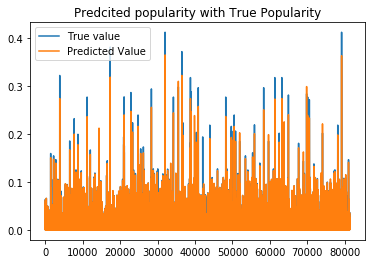

In [0]:
plt.plot(test_y, label = "True value")
plt.plot(predictedY_3, label = "Predicted Value")
plt.legend()
plt.title('Predcited popularity with True Popularity')

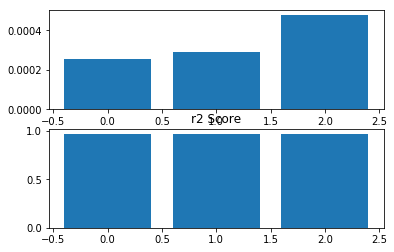

['MAE3:', 0.0002562431, 'MAE2:', 0.00029220502, 'MAE1:', 0.00047703565]
['R2_3:', 0.9703508906575328, 'R2_2:', 0.9732833039644505, 'R2_1:', 0.9690677008793226]


In [0]:
# calculate testing MAE and R^2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as rscore

mae_3=mae(test_y, predictedY_3)
mae_2=mae(test_y, predictedY_2)
mae_1=mae(test_y, predictedY_1)

plt.subplot(2,1,1)
plt.bar(index,[mae_3,mae_2,mae_1])

r2_3=abs(rscore(test_y, predictedY_3))
r2_2=abs(rscore(test_y, predictedY_2))
r2_1=abs(rscore(test_y, predictedY_1))
plt.subplot(2,1,2)
plt.bar(index,[r2_3,r2_2,r2_1])
plt.title('r2 Score')
plt.show()

print(['MAE3:', mae_3, 'MAE2:', mae_2, 'MAE1:', mae_1])
print(['R2_3:', r2_3, 'R2_2:', r2_2, 'R2_1:', r2_1])

In [0]:
train_X.shape

(325234, 1, 9)

In [0]:
#for auto regression analysis as in [1] in paper
from statsmodels.tsa.vector_ar.var_model import VAR

trainData=train_X.reshape(train_X.shape[0],train_X.shape[2])
testData=test_X.reshape(test_X.shape[0],test_X.shape[2])
model_var = VAR(endog=trainData)
model_fit = model_var.fit()
prediction = model_fit.forecast(model_fit.y, steps=len(test_X))
mae_var=mae(testData,prediction)
r2_var=rscore(testData,prediction)
print(['MAE: ',mae_var, 'R2 Score:',r2_var])

/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


['MAE: ', 0.06718205559729441, 'R2 Score:', 0.11108178361374277]


In [0]:
#for linear regression analysis as in [16] in paper
from sklearn import linear_model
# create linear regression object 
reg = linear_model.LinearRegression() 
  
# train the model using the training sets 
reg.fit(trainData, train_y)
predicted_Y_LR=reg.predict(testData) 
mae_lr=mae(test_y,predicted_Y_LR)
r2_lr=rscore(test_y,predicted_Y_LR)
print(['MAE: ',mae_lr, 'R2 Score:',r2_lr])


['MAE: ', 0.00012155962, 'R2 Score:', 0.9745204420273906]


In [0]:
#SVR from [13]
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf',C=1,gamma=0.1)
y_rbf = svr_rbf.fit(trainData,train_y).predict(testData)
mae_rbf=mae(y_rbf,test_y)
r2_rbf=abs(rscore(test_y,y_rbf))
print(['MAE: ',mae_rbf, 'R2 Score:',r2_rbf])

['MAE: ', 0.06325990991639438, 'R2 Score:', 35.75386465537921]


In [0]:
#CNN-LSTM as in [17][18][19]
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense, Bidirectional,MaxPooling1D,BatchNormalization, Dropout,TimeDistributed, LSTM
from keras.layers.convolutional import Conv1D

model_cnnlstm = Sequential()
model_cnnlstm.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model_cnnlstm.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
model_cnnlstm.add(MaxPooling1D(pool_size=1))
model_cnnlstm.add(Flatten())

model_cnnlstm.add(RepeatVector(train_X.shape[1]))
model_cnnlstm.add(LSTM(20, activation='relu', return_sequences=True))
model_cnnlstm.add(TimeDistributed(Dense(100, activation='relu')))
model_cnnlstm.add(TimeDistributed(Dense(1)))
model_cnnlstm.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 16)             160       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 16)             272       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 16)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 1, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 20)             2960      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 100)            2100      
__________

In [0]:
predictedY_CNN=model_cnnlstm.predict(test_X.reshape(test_X.shape[0],1,test_X.shape[2]))

In [0]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as rscore

predictedY_CNN=predictedY_CNN.reshape(predictedY_CNN.shape[0],predictedY_CNN.shape[1])
mae_rbf=mae(predictedY_CNN,test_y)
r2_rbf=abs(rscore(test_y,predictedY_CNN))
print(['MAE: ',mae_rbf, 'R2 Score:',r2_rbf])

['MAE: ', 0.00040307842, 'R2 Score:', 0.9821853633456069]


In [0]:
model_cnnlstm.compile(loss='mae', optimizer='adam')
# fit network
train_y1=train_y.reshape(train_y.shape[0],1, 1)

history_cnnlstm = model_cnnlstm.fit(train_X.reshape(train_X.shape[0],1,train_X.shape[2]), train_y1, epochs=50, batch_size=128, verbose=1, shuffle=False)

W0812 10:49:28.899564 140428172154752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0812 10:49:29.562520 140428172154752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0812 10:49:29.708294 140428172154752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/50
325234/325234 [==============================] - 24s 75us/step - loss: 0.0014
Epoch 2/50
325234/325234 [==============================] - 18s 56us/step - loss: 6.9871e-04
Epoch 3/50
325234/325234 [==============================] - 18s 55us/step - loss: 5.9307e-04
Epoch 4/50
325234/325234 [==============================] - 18s 55us/step - loss: 5.8285e-04
Epoch 5/50
325234/325234 [==============================] - 18s 54us/step - loss: 5.1634e-04
Epoch 6/50
325234/325234 [==============================] - 18s 55us/step - loss: 4.8515e-04
Epoch 7/50
325234/325234 [==============================] - 18s 54us/step - loss: 4.4427e-04
Epoch 8/50
325234/325234 [==============================] - 18s 54us/step - loss: 4.2613e-04
Epoch 9/50
325234/325234 [==============================] - 17s 54us/step - loss: 3.8836e-04
Epoch 10/50
325234/325234 [==============================] - 18s 54us/step - loss: 4.0196e-04
Epoch 11/50
325234/325234 [==============================] - 18s 55us/ste